# Solve Generalized Eigenvalue Problem of observed covariance

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## prepare covariances
the same criterion of lambda is assumed as B2K

In [2]:
LAMBDA = 0.98

In [3]:
PREFIX = 'observed'

In [4]:
nside = 64

In [5]:
%%time
cov_bb = np.load('{:}_ana_cov_only_bb_nisde{:03d}.npy'.format(PREFIX,nside))
cov_ee = np.load('{:}_ana_cov_only_ee_nisde{:03d}.npy'.format(PREFIX,nside))

CPU times: user 30 µs, sys: 1.24 s, total: 1.24 s
Wall time: 1.24 s


also the same sigma is assumed

In [6]:
nums = cov_bb.shape[0]
f_sigma = 0.01
sigma2 = np.mean((cov_bb.diagonal()+cov_ee.diagonal())/2) * f_sigma

In [7]:
len(np.nonzero(cov_bb)[0])/nums**2

0.9233930054838947

Unfortunately it is NOT a sparse matrix! It should be a parse matrix in the full sky, but it is not because the matrix is already an observed partial sky, I guess. 

## solve GEP
Here eigh in scipy is used if no GPU supprted. Need better implementation for higher nside.

In [8]:
def get_cupy():
    try:
        import cupy as cp
        pool = cp.cuda.MemoryPool(cp.cuda.malloc_managed)
        cp.cuda.set_allocator(pool.malloc)
        print('Now GPU is being used!')
        return cp
    except ImportError:
        return False

def GEP(A, B):
    cp = get_cupy()
    if cp:
        # Reduce the problem to a standard symmetric eigenvalue problem
        Linv = cp.linalg.inv(cp.linalg.cholesky(cp.asarray(B)))
        lamda,V = cp.linalg.eigh(Linv @ cp.asarray(A) @ Linv.T)
        return cp.asnumpy(lamda), cp.asnumpy(Linv.T @ V)
    else:
        # this could fail w/ nside>128?
        from scipy.linalg import eigh
        return eigh(A, B)

In [9]:
%%time
eigvals, eigvecs = GEP(cov_bb + sigma2 * np.eye(nums), cov_ee + sigma2 * np.eye(nums))

Now GPU is being used!
CPU times: user 10.1 s, sys: 11.9 s, total: 22 s
Wall time: 22 s


Note it takes 3 min w/ CPU for nside=64 using 96 threads (20 "sec" w/ GPU).

In [10]:
norm_eigvecs = eigvecs/np.linalg.norm(eigvecs, axis=0, keepdims=True)

## plot eigenvalues spectrum

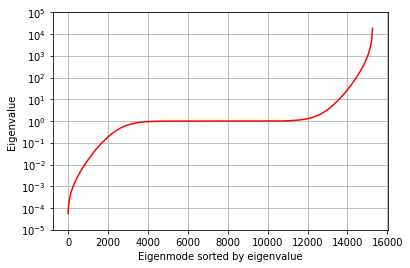

In [11]:
v = eigvals
plt.plot(v, 'r-')
plt.xlabel('Eigenmode sorted by eigenvalue')
plt.ylabel('Eigenvalue')
plt.yscale('log')

ytics = []
pmin = int(np.log10(np.min(v)))-1
pmax = int(np.log10(np.max(v)))+1
p = pmin
while True:
    ytics.append(10**p)
    p += 1
    if p > pmax:
        break
plt.yticks(ytics)
plt.grid()

## apply the criterion

In [12]:
lens = np.searchsorted(eigvals > LAMBDA, True)
nums, lens, eigvals[:lens][-1], eigvals[-lens:][0]

(15256, 4388, 0.979968854044709, 1.0198430596994734)

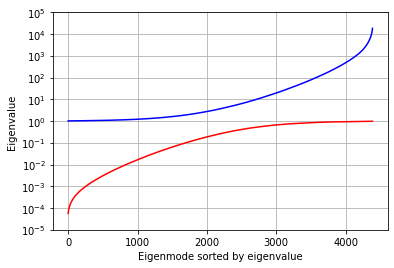

In [13]:
v = eigvals
plt.plot(v[:lens], 'r-')
plt.plot(v[-lens:], 'b-')
plt.xlabel('Eigenmode sorted by eigenvalue')
plt.ylabel('Eigenvalue')
plt.yscale('log')
plt.yticks(ytics)
plt.grid()

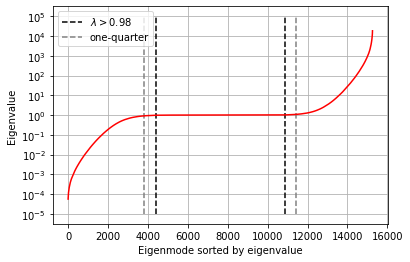

In [14]:
v = eigvals
plt.plot(v, 'r-')
plt.xlabel('Eigenmode sorted by eigenvalue')
plt.ylabel('Eigenvalue')
plt.yscale('log')

ytics = []
pmin = int(np.log10(np.min(v)))-1
pmax = int(np.log10(np.max(v)))+1
p = pmin
while True:
    ytics.append(10**p)
    p += 1
    if p > pmax:
        break
plt.yticks(ytics)
plt.vlines(x=lens, ymin=10**pmin, ymax=10**pmax, ls='--', colors='black')
plt.vlines(x=nums-lens, ymin=10**pmin, ymax=10**pmax, ls='--', colors='black', label='$\lambda>{:.2f}$'.format(LAMBDA))
plt.vlines(x=nums//4, ymin=10**pmin, ymax=10**pmax, ls='--', colors='gray')
plt.vlines(x=3*nums//4, ymin=10**pmin, ymax=10**pmax, ls='--', colors='gray', label='one-quarter')
plt.legend()
plt.grid()

In [15]:
# 1/4 criterion
lens = nums // 4
nums, lens, eigvals[:lens][-1], eigvals[-lens:][0]

(15256, 3814, 0.9158954034088325, 1.0877816382794991)

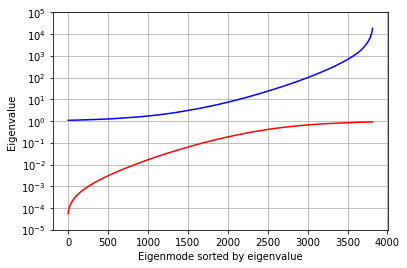

In [16]:
v = eigvals
plt.plot(v[:lens], 'r-')
plt.plot(v[-lens:], 'b-')
plt.xlabel('Eigenmode sorted by eigenvalue')
plt.ylabel('Eigenvalue')
plt.yscale('log')
plt.yticks(ytics)
plt.grid()

In [17]:
%%time
np.savez('{:}_eigen_spectrum_nside{:03d}'.format(PREFIX,nside),
         eigvals=eigvals, eigvecs=eigvecs, norm_eigvecs=norm_eigvecs)

CPU times: user 2.75 s, sys: 1.65 s, total: 4.4 s
Wall time: 4.39 s
